# Target

- Solve a classification problem with deep neural networks (DNNs)
    - concat n frames
    - add layers : Implement 2 models with approximately the same number of parameters, (A) one narrower and deeper (e.g. hidden_layers=6, hidden_dim=1024) and (B) the other wider and shallower (e.g. hidden_layers=2, hidden_dim=1750). Report training/validation accuracies for both models.
    - batchnorm, dropout : Add dropout layers, and report training/validation accuracies with dropout rates equal to (A) 0.25/(B) 0.5/(C) 0.75 respectively.

- Solve a classification problem with recursive neural networks (RNNs).




# Library

In [4]:
import random
import os
import argparse
from tqdm import tqdm

import numpy as np

from torch.utils.data import Dataset
import torch.nn as nn
import torch
from torch.utils.data import DataLoader
import gc

# Helper function

- `random.seed(seed)`: Sets the seed for **Python's built-in** random module.
- `np.random.seed(seed)`: Sets the seed for **NumPy's** random number generator.
- `torch.manual_seed(seed)`: Sets the seed for **PyTorch on the CPU**.
- `torch.cuda.manual_seed(seed)`: Sets the seed for the **current GPU**.
- `torch.cuda.manual_seed_all(seed)`: Sets the seed for **all GPUs**.
- `torch.backends.cudnn.benchmark = False`: Disables the CuDNN benchmark mode.
- `torch.backends.cudnn.deterministic = True`: Forces CuDNN to use deterministic algorithms, which helps in reproducibility.

`torch.backends.cudnn.benchmark` 是 PyTorch 的一個設置，用來啟用或禁用 CuDNN 的基準模式：

- True：讓 CuDNN 尋找最佳的卷積算法，可能提高訓練速度，但結果可能不可重現。
- False：使用固定的算法，確保結果可重現，通常用於測試和比較實驗結果。

**在追求可重現性時，可設置為 False**

In [5]:
def same_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmarkbe = False
    torch.backends.cudnn.deterministic = True

- 函數：

`load_feat(path)`：

    從指定路徑加載 PyTorch 張量。

`shift(x, n)`：

    將張量 x 向左或向右移動 n 個位置。
    根據移動方向用第一或最後一個元素填充。

`concat_feat(x, concat_n)`：

    在每個幀周圍串聯 concat_n 幀。
    確保 concat_n 是奇數。
    使用 shift 函數來正確調整每個幀。

- 主函數：
`preprocess_data(split, feat_dir, phone_path, concat_nframes, train_ratio=0.8)`：

    用於訓練、驗證或測試的數據預處理。
    加載和串聯特徵。
    根據 train_ratio 將數據拆分為訓練集和驗證集。
    
    - 步驟：

        - 加載數據：

            讀取標籤並拆分數據集。
            使用 load_feat 加載特徵文件。
            特徵串聯：

            使用 concat_feat 串聯幀以提供上下文。
            數據準備：

            為特徵 (X) 和標籤 (y) 準備張量。

        - 輸出：

            返回處理好的訓練/驗證集的特徵和標籤張量，或僅返回測試集的特徵。
            關鍵點：
            concat_nframes 必須是奇數以確保對稱上下文。
            train_ratio 控制訓練和驗證之間的拆分比例。
            預定義的最大長度 (max_len) 保證了內存的高效分配，可以根據需要調整。
            使用 tqdm 來追踪進度。

---

In [6]:
def load_feat(path):
    feat = torch.load(path)
    return feat

def shift(x: torch.Tensor, n: int) -> torch.Tensor:
    if n < 0:
        left = x[0].repeat(-n, 1)
        right = x[:n]
    elif n > 0:
        right = x[-1].repeat(n, 1)
        left = x[n:]
    else:
        return x

    return torch.cat((left, right), dim=0)

def concat_feat(x: torch.Tensor, concat_n: int):
    assert concat_n % 2 == 1 # n must be odd
    if concat_n < 2:
        return x
    seq_len, feature_dim = x.size(0), x.size(1)
    x = x.repeat(1, concat_n) 
    x = x.view(seq_len, concat_n, feature_dim).permute(1, 0, 2) # concat_n, seq_len, feature_dim
    mid = (concat_n // 2)
    for r_idx in range(1, mid+1):
        x[mid + r_idx, :] = shift(x[mid + r_idx], r_idx)
        x[mid - r_idx, :] = shift(x[mid - r_idx], -r_idx)

    return x.permute(1, 0, 2).view(seq_len, concat_n * feature_dim)


**Explain**

In [99]:
test = torch.Tensor([[1,2,3],
                     [4,5,6],
                     [7,8,9],
                     [10,11,12]])

shift(test,2)

tensor([[ 7.,  8.,  9.],
        [10., 11., 12.],
        [10., 11., 12.],
        [10., 11., 12.]])

In [100]:
test.shape

torch.Size([4, 3])

In [101]:
test.repeat(1, 3).shape

torch.Size([4, 9])

In [102]:
seq_len, feature_len = test.size(0), test.size(1) # 4*3
test = test.repeat(1, 3) # 4*9
test.view(seq_len, 3, feature_len) # 4 *3 *3

tensor([[[ 1.,  2.,  3.],
         [ 1.,  2.,  3.],
         [ 1.,  2.,  3.]],

        [[ 4.,  5.,  6.],
         [ 4.,  5.,  6.],
         [ 4.,  5.,  6.]],

        [[ 7.,  8.,  9.],
         [ 7.,  8.,  9.],
         [ 7.,  8.,  9.]],

        [[10., 11., 12.],
         [10., 11., 12.],
         [10., 11., 12.]]])

In [105]:
test = test.view(seq_len, 3, feature_len).permute(1, 0, 2)

In [106]:
test  # 3*4*3 permute() rearange tensor

tensor([[[ 1.,  2.,  3.],
         [ 4.,  5.,  6.],
         [ 7.,  8.,  9.],
         [10., 11., 12.]],

        [[ 1.,  2.,  3.],
         [ 4.,  5.,  6.],
         [ 7.,  8.,  9.],
         [10., 11., 12.]],

        [[ 1.,  2.,  3.],
         [ 4.,  5.,  6.],
         [ 7.,  8.,  9.],
         [10., 11., 12.]]])

In [107]:
mid = (3 // 2) # 1
for r_idx in range(1, mid+1): # 1
    a = shift(test[mid + r_idx], r_idx)
    test[mid + r_idx, :] = a
    print(a)

    b = shift(test[mid - r_idx], -r_idx)
    test[mid - r_idx, :] = b
    print(b)

tensor([[ 4.,  5.,  6.],
        [ 7.,  8.,  9.],
        [10., 11., 12.],
        [10., 11., 12.]])
tensor([[1., 2., 3.],
        [1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])


In [109]:
test.permute(1, 0, 2).view(seq_len, 3 * feature_len) # 4*9

tensor([[ 1.,  2.,  3.,  1.,  2.,  3.,  4.,  5.,  6.],
        [ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.],
        [ 4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.],
        [ 7.,  8.,  9., 10., 11., 12., 10., 11., 12.]])

---

In [7]:
def preprocess_data(split: str, feat_dir, phone_path, concat_nframes, train_ratio=0.8):
    class_num = 41 # NOTE: pre-computed, should not need change

    if split == 'train' or split == 'val':
        mode = 'train'
    elif split == 'test':
        mode = 'test'
    else:
        raise ValueError('Invalid \'split\' argument for dataset: PhoneDataset!')

    label_dict = {}
    if mode == 'train':
        for line in open(os.path.join(phone_path, f'{mode}_labels.txt')).readlines():
            line = line.strip('\n').split(' ')
            label_dict[line[0]] = [int(p) for p in line[1:]]
        
        # split training and validation data
        usage_list = open(os.path.join(phone_path, 'train_split.txt')).readlines()
        random.shuffle(usage_list)
        train_len = int(len(usage_list) * train_ratio)
        usage_list = usage_list[:train_len] if split == 'train' else usage_list[train_len:]

    elif mode == 'test':
        usage_list = open(os.path.join(phone_path, 'test_split.txt')).readlines()

    usage_list = [line.strip('\n') for line in usage_list]
    print('[Dataset] - # phone classes: ' + str(class_num) + ', number of utterances for ' + split + ': ' + str(len(usage_list)))

    max_len = 3000000
    X = torch.empty(max_len, 39 * concat_nframes)
    if mode == 'train':
        y = torch.empty(max_len, dtype=torch.long)

    idx = 0
    for i, fname in tqdm(enumerate(usage_list)):
        feat = load_feat(os.path.join(feat_dir, mode, f'{fname}.pt'))
        cur_len = len(feat)
        feat = concat_feat(feat, concat_nframes)
        if mode == 'train':
            label = torch.LongTensor(label_dict[fname])

        X[idx: idx + cur_len, :] = feat
        if mode == 'train':
            y[idx: idx + cur_len] = label

        idx += cur_len

    X = X[:idx, :]
    if mode == 'train':
        y = y[:idx]

    print(f'[INFO] {split} set')
    print(X.shape)
    if mode == 'train':
        print(y.shape)
        return X, y
    else:
        return X

**Explain**

In [131]:
label_dict = {}
for line in open("/kaggle/input/libraphone/libriphone/train_labels.txt").readlines():
    print(len(line))
    line = line.strip('\n').split(' ')
    print(len(line))
    label_dict[line[0]] = [int(p) for p in line[1:]]
    print(label_dict)
    break



2121
841
{'4830-25898-0031': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12, 12, 12, 12, 12, 12, 12, 27, 27, 27, 38, 38, 38, 38, 38, 38, 38, 35, 35, 35, 35, 35, 25, 25, 25, 25, 25, 25, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 37, 37, 37, 37, 37, 30, 30, 30, 30, 30, 30, 30, 30, 27, 27, 27, 4, 4, 4, 4, 31, 31, 31, 31, 31, 30, 30, 30, 30, 30, 30, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 30, 30, 30, 30, 30, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 8, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 27, 27, 27, 27, 27, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 27, 27, 27, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 37, 37, 37, 37, 37, 37, 14, 14, 14, 14, 14, 14, 14, 4, 4, 4, 4, 4, 4, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 32, 32, 32, 32, 32, 32, 32, 

In [133]:
split = "train"

usage_list = open("/kaggle/input/libraphone/libriphone/train_split.txt").readlines()
print(f"read first: {usage_list[0]}")
random.shuffle(usage_list)
print(f"After shuffling: {usage_list[0]}")
train_len = int(len(usage_list) * 0.8)
usage_list = usage_list[:train_len] if split == 'train' else usage_list[train_len:]
print(f"After train split: {usage_list[0]}")
usage_list = [line.strip('\n') for line in usage_list]
print(f"Strip \\n: {usage_list[0]}")
print('[Dataset] - # phone classes: ' + str(41) + ', number of utterances for ' + split + ': ' + str(len(usage_list)))

read first: 4830-25898-0031

After shuffling: 2989-138028-0022

After train split: 2989-138028-0022

Strip \n: 2989-138028-0022
[Dataset] - # phone classes: 41, number of utterances for train: 2743


----

# Dataset


In [8]:
class LibriDataset(Dataset):
    def __init__(self, X, y=None):
        self.data = X
        if y is not None:
            self.label = torch.LongTensor(y)
        else:
            self.label = None

    def __getitem__(self, idx):
        if self.label is not None:
            return self.data[idx], self.label[idx]
        else:
            return self.data[idx]

    def __len__(self):
        return len(self.data)

# Model

Base : Linear -> ReLU -> Linear ... + one narrower and deeper (hidden_layers=2, hidden_dim=64)

1. Linear -> ReLU -> Linear ... + one narrower and deeper (hidden_layers=6, hidden_dim=1024)

2.  Linear -> ReLU -> Linear ... + wider and shallower (hidden_layers=2, hidden_dim=1750)

*use best perform in 1 or 2 to train follow model*
3. Linear -> ReLU -> Dropout(.25_ -> Linear... 

4. Linear -> ReLU -> Dropout(.5) -> Linear ...

5. Linear -> ReLU -> Dropout(.75) -> Linear ...

*use best perform in 3, 4 or 5 to train follow model*

6. Linear -> BN -> ReLU -> Dropout -> Linear ...

7. Linear -> ReLU ->  Dropout -> BN -> Linear ...

8. Concat 3, 5, 7, 9 frames

9. RNN

In [34]:
class BasicBlock(nn.Module):
    def __init__(self,
                 input_dim,
                 output_dim,
                 eps=1e-05,
                 momentum=0.1,
                 drop_out_p = 0.5):
        
        super().__init__()

        self.block = nn.Sequential(
            nn.Linear(input_dim, output_dim),
            #nn.BatchNorm2d(output_dim, eps=eps, momentum=momentum, affine=True),
            nn.ReLU(),
            #nn.Dropout(drop_out_p)
        )

    def forward(self, x):
        x = self.block(x)
        return x


class Classifier(nn.Module):
    def __init__(self,
                 input_dim,
                 output_dim=41,
                 hidden_layers=1,
                 hidden_dim=256):
        
        super().__init__()

        self.fc = nn.Sequential(
            BasicBlock(input_dim, hidden_dim),
            *[BasicBlock(hidden_dim, hidden_dim) for _ in range(hidden_layers)],
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        x = self.fc(x)
        return x

# Hyper-parameters

In [ ]:
parser = argparse.ArgumentParser(description='設定資料與訓練參數')

# 資料參數
parser.add_argument('--concat_nframes', type=int, default=3,
                    help='連接的幀數，n 必須為奇數 (總共 2k+1 = n 幀)')
parser.add_argument('--train_ratio', type=float, default=0.75,
                    help='訓練資料比例，其餘將用於驗證')

# 訓練參數
parser.add_argument('--seed', type=int, default=1213,
                    help='隨機種子')
parser.add_argument('--batch_size', type=int, default=512,
                    help='批次大小')
parser.add_argument('--num_epoch', type=int, default=10,
                    help='訓練的 epoch 數量')
parser.add_argument('--learning_rate', type=float, default=1e-4,
                    help='學習率')
parser.add_argument('--model_path', type=str, default='./model.ckpt',
                    help='模型儲存的路徑')

# 模型參數
parser.add_argument('--input_dim', type=int, default=39 * 3,
                    help='模型的輸入維度，不應更改此值')
parser.add_argument('--hidden_layers', type=int, default=2,
                    help='隱藏層的層數')
parser.add_argument('--hidden_dim', type=int, default=64,
                    help='隱藏層的維度')

args = parser.parse_args()

# 打印參數設定
print('資料參數:')
print(f'- 連接的幀數: {args.concat_nframes}')
print(f'- 訓練資料比例: {args.train_ratio}')

print('\n訓練參數:')
print(f'- 隨機種子: {args.seed}')
print(f'- 批次大小: {args.batch_size}')
print(f'- 訓練 epoch 數量: {args.num_epoch}')
print(f'- 學習率: {args.learning_rate}')
print(f'- 模型儲存路徑: {args.model_path}')

print('\n模型參數:')
print(f'- 輸入維度: {args.input_dim}')
print(f'- 隱藏層數量: {args.hidden_layers}')
print(f'- 隱藏層維度: {args.hidden_dim}')

In [35]:
# data prarameters
concat_nframes = 3              # the number of frames to concat with, n must be odd (total 2k+1 = n frames)
train_ratio = 0.75               # the ratio of data used for training, the rest will be used for validation

# training parameters
seed = 1213                        # random seed
batch_size = 512                # batch size
num_epoch = 10                   # the number of training epoch
learning_rate = 1e-4         # learning rate
model_path = './model_2.ckpt'     # the path where the checkpoint will be saved

# model parameters
input_dim = 39 * concat_nframes # the input dim of the model, you should not change the value
hidden_layers = 6               # the number of hidden layers
hidden_dim = 1024                # the hidden dim

# Dataloader

In [11]:
same_seeds(seed)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'DEVICE: {device}')

DEVICE: cuda


In [36]:
# preprocess data
train_X, train_y = preprocess_data(split='train',
                                   feat_dir='/kaggle/input/libraphone/libriphone/feat',
                                   phone_path='/kaggle/input/libraphone/libriphone',
                                   concat_nframes=concat_nframes,
                                   train_ratio=train_ratio)

val_X, val_y = preprocess_data(split='val',
                               feat_dir='/kaggle/input/libraphone/libriphone/feat',
                               phone_path='/kaggle/input/libraphone/libriphone',
                               concat_nframes=concat_nframes,
                               train_ratio=train_ratio)

[Dataset] - # phone classes: 41, number of utterances for train: 2571


2571it [00:05, 460.69it/s]


[INFO] train set
torch.Size([1592165, 117])
torch.Size([1592165])
[Dataset] - # phone classes: 41, number of utterances for val: 858


858it [00:01, 594.35it/s]

[INFO] val set
torch.Size([534875, 117])
torch.Size([534875])


In [37]:
# get dataset
train_set = LibriDataset(train_X, train_y)
val_set = LibriDataset(val_X, val_y)

In [38]:
# remove raw feature to save memory
del train_X, train_y, val_X, val_y
gc.collect()

5092

In [39]:
# get dataloader
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

# Training

In [162]:
next(iter(train_loader))[0].shape

torch.Size([512, 117])

In [161]:
next(iter(train_loader))[1].shape

torch.Size([512])

In [40]:
# data prarameters
concat_nframes = 3              # the number of frames to concat with, n must be odd (total 2k+1 = n frames)
train_ratio = 0.75               # the ratio of data used for training, the rest will be used for validation

# training parameters
seed = 1213                        # random seed
batch_size = 512                # batch size
num_epoch = 10                   # the number of training epoch
learning_rate = 1e-4         # learning rate
model_path = './model_2.ckpt'     # the path where the checkpoint will be saved

# model parameters
input_dim = 39 * concat_nframes # the input dim of the model, you should not change the value
hidden_layers = 2               # the number of hidden layers
hidden_dim = 64                # the hidden dim

In [41]:
# create model, define a loss function, and optimizer
model = Classifier(input_dim=input_dim, hidden_layers=hidden_layers, hidden_dim=hidden_dim).to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [20]:
len(train_loader.dataset), len(train_loader)

(1588590, 3103)

In [42]:
def train(model: torch.nn.Module,
          data_loader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          device: torch.device):
    model.train()
    train_acc = 0.0
    train_loss = 0.0
    for features, labels in tqdm(data_loader):
        features, labels = features.to(device), labels.to(device)
        # 1. Froward pass
        outputs = model(features)
        
         # 2. Calculate loss
        loss = loss_fn(outputs, labels)
        
        # 3. Optimizer zer grade
        optimizer.zero_grad()
        
        # 4. Loss backward
        loss.backward()
        
        # 5. optimizer step
        optimizer.step()
        
        _, train_pred = torch.max(outputs, 1)
        train_acc += (train_pred == labels).sum().item()
        train_loss += loss.item()
        
    return train_acc / len(data_loader.dataset), train_loss / len(data_loader) #data_loader.dataset total sample size and data_loader batch size

def validate(model: torch.nn.Module,
             data_loader: torch.utils.data.DataLoader,
             loss_fn: torch.nn.Module,
             device: torch.device):
    model.eval()
    val_acc = 0.0
    val_loss = 0.0
    with torch.no_grad():
        for features, labels in tqdm(data_loader):
            features, labels = features.to(device), labels.to(device)
            
            outputs = model(features)
            loss = loss_fn(outputs, labels)
            
            _, val_pred = torch.max(outputs, 1)
            val_acc += (val_pred == labels).sum().item()
            val_loss += loss.item()
            
    return val_acc / len(data_loader.dataset), val_loss / len(data_loader)


# Main training loop
best_acc = 0.0
train_info = {
    "Acc":[],
    "Loss":[]
}
val_info = {
    "Acc":[],
    "Loss":[]
}
for epoch in range(num_epoch):
    train_acc, train_loss = train(model, train_loader, criterion, optimizer, device)
    val_acc, val_loss = validate(model, val_loader, criterion, device)
    train_info["Acc"].append(train_acc)
    train_info["Loss"].append(train_loss)
    val_info["Acc"].append(val_acc)
    val_info["Loss"].append(val_loss)
    print(f'[{epoch+1:03d}/{num_epoch:03d}] Train Acc: {train_acc:.5f} Loss: {train_loss:.5f} | Val Acc: {val_acc:.5f} Loss: {val_loss:.5f}')

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), model_path)
        print(f'Saving model with acc {best_acc:.5f}')


100%|██████████| 1045/1045 [00:04<00:00, 232.43it/s]


[001/010] Train Acc: 0.39095 Loss: 2.20904 | Val Acc: 0.43926 Loss: 1.96866
Saving model with acc 0.43926


100%|██████████| 1045/1045 [00:04<00:00, 231.88it/s]


[002/010] Train Acc: 0.45037 Loss: 1.92448 | Val Acc: 0.45846 Loss: 1.88578
Saving model with acc 0.45846


100%|██████████| 1045/1045 [00:04<00:00, 231.03it/s]


[003/010] Train Acc: 0.46469 Loss: 1.86240 | Val Acc: 0.46957 Loss: 1.84023
Saving model with acc 0.46957


100%|██████████| 1045/1045 [00:04<00:00, 228.57it/s]


[004/010] Train Acc: 0.47416 Loss: 1.82347 | Val Acc: 0.47744 Loss: 1.80752
Saving model with acc 0.47744


100%|██████████| 1045/1045 [00:04<00:00, 231.60it/s]


[005/010] Train Acc: 0.48090 Loss: 1.79544 | Val Acc: 0.48306 Loss: 1.78394
Saving model with acc 0.48306


100%|██████████| 1045/1045 [00:04<00:00, 229.97it/s]


[006/010] Train Acc: 0.48583 Loss: 1.77368 | Val Acc: 0.48751 Loss: 1.76481
Saving model with acc 0.48751


100%|██████████| 1045/1045 [00:04<00:00, 230.58it/s]


[007/010] Train Acc: 0.49001 Loss: 1.75611 | Val Acc: 0.49091 Loss: 1.74884
Saving model with acc 0.49091


100%|██████████| 1045/1045 [00:04<00:00, 225.79it/s]


[008/010] Train Acc: 0.49332 Loss: 1.74117 | Val Acc: 0.49357 Loss: 1.73566
Saving model with acc 0.49357


100%|██████████| 1045/1045 [00:04<00:00, 232.40it/s]


[009/010] Train Acc: 0.49613 Loss: 1.72832 | Val Acc: 0.49676 Loss: 1.72442
Saving model with acc 0.49676


100%|██████████| 1045/1045 [00:04<00:00, 231.87it/s]

[010/010] Train Acc: 0.49872 Loss: 1.71699 | Val Acc: 0.49931 Loss: 1.71351
Saving model with acc 0.49931


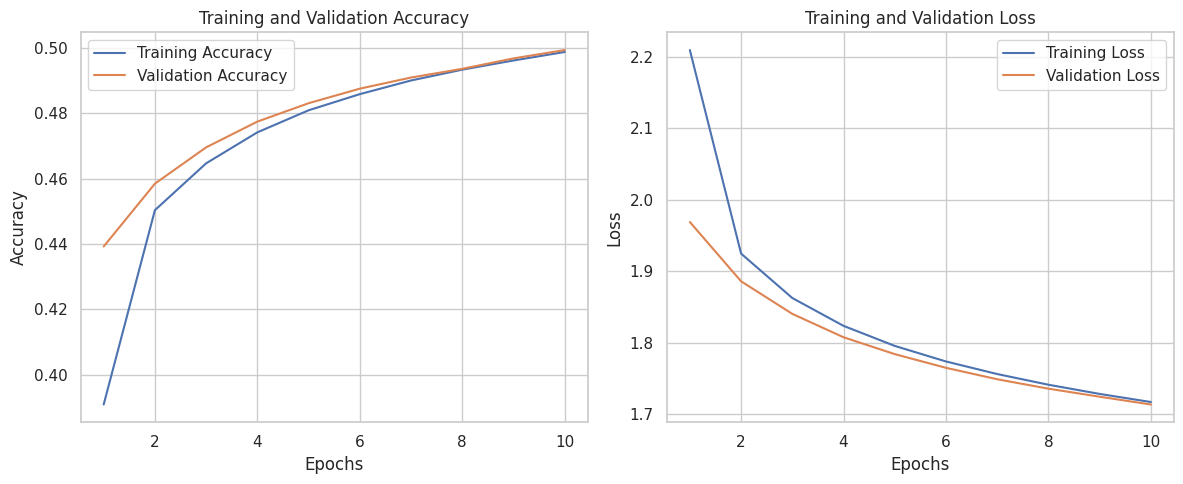

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Plotting the results with Seaborn
epochs = range(1, num_epoch + 1)

sns.set(style='whitegrid')

plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
sns.lineplot(x=epochs, y=train_info["Acc"], label='Training Accuracy')
sns.lineplot(x=epochs, y=val_info["Acc"], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
sns.lineplot(x=epochs, y=train_info["Loss"], label='Training Loss')
sns.lineplot(x=epochs, y=val_info["Loss"], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.tight_layout()
plt.savefig("Model_2.png")
plt.show()

# Compare Result with different Model

**Base**

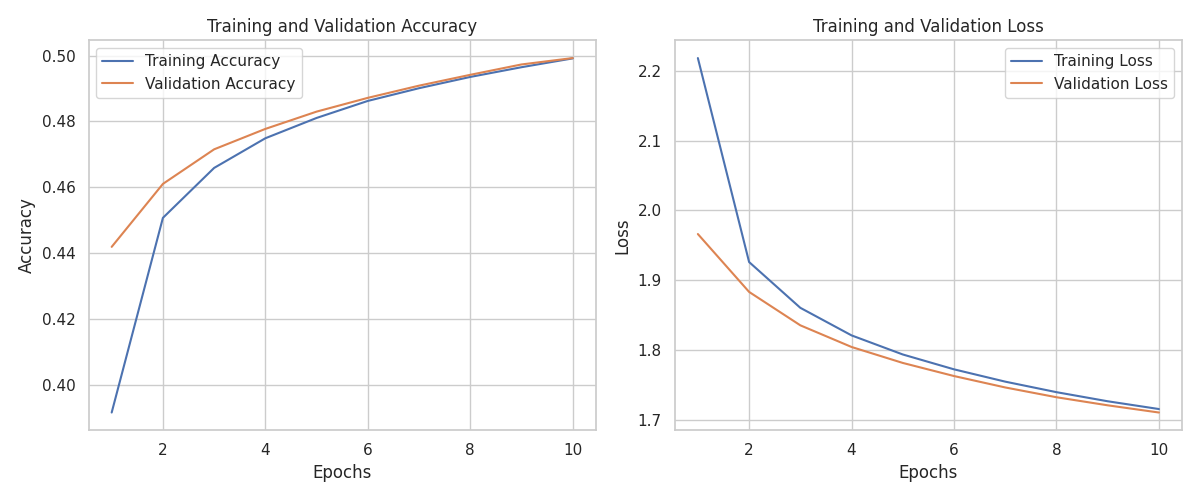

**Narrow and Depper**

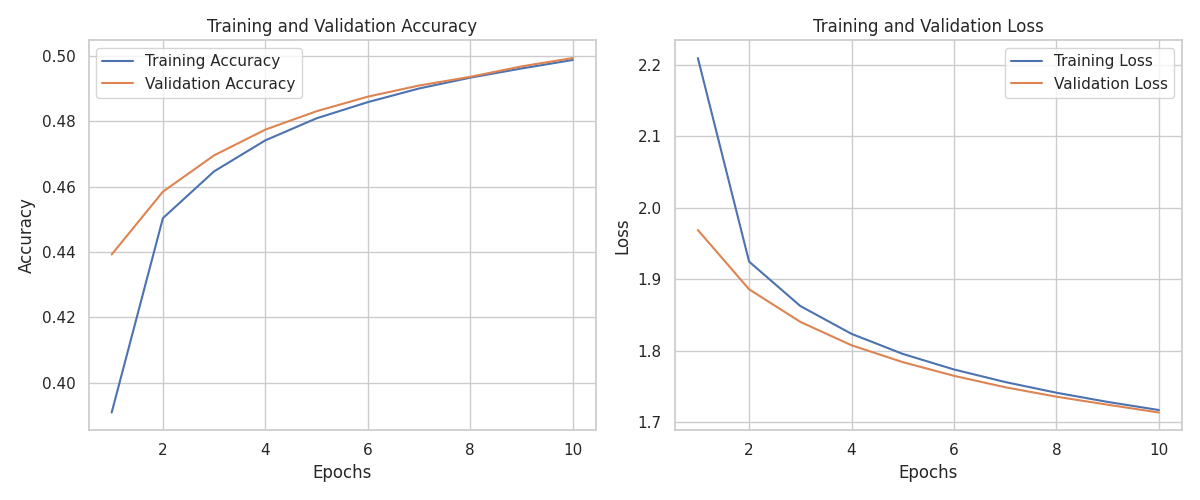